# Train a CNN on the color-based training set.
Assume training patches are in files on disk. See DF_Filter.011  
Here, work out loading them as needed for training.  
One issue is cuda.  
Another issue is the TensorFlow Data API.  

Directory structure is
* cache  
    * train  
        * 0  (green) 2680 files
        * 1   (blue) 3099 files
    * valid  
        * 0  (green) 266 files
        * 1   (blue) 311 files

Filename like F5..208 or F15.209.tif i.e. original_image.patch num.tif  
All prefixes are 3 characters with either one or two dots.  
Patch nums are per category.  
Each file holds a 224x224 patch of a color image.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/cache/"
PATCH_SIZE=224  # matches VGG
BLUE=1
GREEN=0

In [3]:
# TO DO: normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1./255)

In [4]:
# TO DO: load patches in random order
# TO DO: or, give patch files randome names
class patch_loader:
    def __init__(self):
        pass
    def load_pixel_array(self,filename):
        im = Image.open(filename)
        ima = np.array(im)   # convert to numpy
        return ima
    def load_dataset(self,path,tv,label,max_files=None):
        file_count=0
        images=[]
        labels=[]
        pstr = path+tv+'/'+str(label)+'/*.tif'
        fullpaths = glob.glob(pstr)
        # names = [os.path.basename(x) for x in fullpaths]
        for name in fullpaths:
            file_count += 1
            if file_count <= max_files:
                ima = self.load_pixel_array(name)
                images.append(ima)
                labels.append(label)
        return images,labels

In [5]:
X_train=[]
Y_train=[]
X_valid=[]
Y_valid=[]
pl = patch_loader()
greenX,greenY = pl.load_dataset(DIR_IMAGES_IN,'train',GREEN,max_files=10)
blueX, blueY =  pl.load_dataset(DIR_IMAGES_IN,'train',BLUE,max_files=10)
X_train = greenX + blueX
Y_train = greenY + blueY
# Required for tensorflow+
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid)
Y_valid = np.asarray(Y_valid)

In [6]:
print(Y_train)
print(type(X_train))
print(len(X_train))
print(X_train[0].shape)


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
<class 'numpy.ndarray'>
20
(224, 224, 3)


In [7]:
ACTIVATION="tanh"
NUM_CLASSES = 2
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,3]
cnn = keras.models.Sequential([
    kl.Conv2D(filters=64,kernel_size=7,activation=ACTIVATION,padding="SAME",
    input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(128,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(64,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(2,activation="softmax")
])
# 10 nodes in the output layer
# corresponds to 10 classes of MNIST clothes.
# cnn.layers[0].weights

In [8]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = cnn.fit(X_train,Y_train,epochs=EPOCHS,
                 validation_data=(X_valid,Y_valid))
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.2341 - accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2235 - accuracy: 0.9000
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 2.0257 - accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 3.9867 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 3.0022 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 2.6845 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 2.4881 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 1.7762 - accuracy: 0.5500
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 1.3786 - accuracy: 0.5500
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 1.5889 - accuracy: 0.5500
Elapsed time: 3.674388647079467

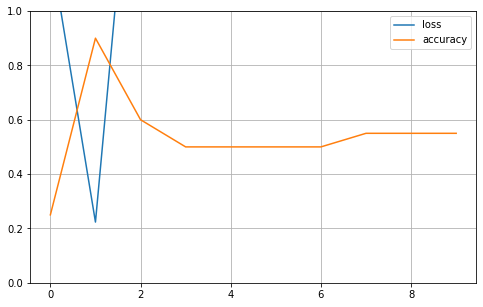

In [9]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

022-02-15 09:21:18.088128: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-15 09:21:18.088162: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Alien): /proc/driver/nvidia/version does not exist
2022-02-15 09:21:18.088620: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[I 09:22:14.940 NotebookApp] Saving file at /TumorI/DF_Filter.012.ipynb

This line of code made the error go away:
 os.environ['CUDA_VISIBLE_DEVICES'] = "0"
 
But the CPU was not used. We reset Ubunto Software Driver from X.org to nvidia 470 and rebooted.  

Time per epoch dropped from 3s/step to 74ms/step.


2022-02-15 09:44:45.319996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.371246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.371828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.372891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-15 09:44:45.373771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.374310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.374802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.898533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.899021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.899447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:44:45.899861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9260 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2022-02-15 09:44:47.104394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302

2022-02-15 09:44:47.771946: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
ShepherdML$ [I 09:46:37.734 NotebookApp] Saving file at /TumorI/DF_Filter.012.ipynb


~$ nvcc --version  
nvcc: NVIDIA (R) Cuda compiler driver  
Copyright (c) 2005-2019 NVIDIA Corporation  
Built on Sun_Jul_28_19:07:16_PDT_2019  
Cuda compilation tools, release 10.1, V10.1.243  

## Reinstall
Firefox (using X) was precluding the driver install.  
Firefox loads Xorg libraries into the running kernel.  
Must reboot and run only a terminal.  
Run the cuda.11.run file from nvidia  
Make sure nothing else is running!  

ShepherdML$ nvcc --version   
nvcc: NVIDIA (R) Cuda compiler driver  
Copyright (c) 2005-2021 NVIDIA Corporation  
Built on Fri_Dec_17_18:16:03_PST_2021  
Cuda compilation tools, release 11.6, V11.6.55  
Build cuda_11.6.r11.6/compiler.30794723_0  

## Finally! A run with no cuda errors.

2022-02-15 11:13:27.103349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-02-15 11:13:27.103495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9340 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2022-02-15 11:13:28.249527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


## No learning? Well that's my next problem.